## Import libraries

In [1]:
import pandas as pd
import numpy as np
import tweepy
import us
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from adjustText import adjust_text
from datetime import timedelta

## Set library parameters

In [2]:
# Pandas display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', -1)

# Pandas + matplotlib
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

# Pyplot options
plt.rcParams.update({'font.size': 16, 'font.sans-serif': 'Arial'})

In [3]:
covid_strings = 'coronavirus|covid|ncov'

## Import data

### Tweets

Data downloaded from the `tweets` sheet of `https://corona-tweets.datasettecloud.com` on 2020/04/01 ~10:49 AM PST (after filtering for `created_at` > `2019-12-01`)

In [4]:
tweets_sheet = '../data/source/tweets_20200401-1048PST.csv'
df_tweets = pd.read_csv(tweets_sheet, dtype={'user': object})
df_tweets.head()

/Users/ihwang/.local/share/virtualenvs/covid19-tweets-jKmwAzGh/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (29) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,id,user,user_label,created_at,full_text,retweeted_status,retweeted_status_label,quoted_status,quoted_status_label,place,place_label,source,source_label,truncated,display_text_range,in_reply_to_status_id,in_reply_to_user_id,in_reply_to_screen_name,geo,coordinates,contributors,is_quote_status,retweet_count,favorite_count,favorited,retweeted,lang,possibly_sensitive,scopes,withheld_in_countries
0,1200927511900766208,38349184,Office of the Governor of California,2019-12-01T00:00:05+00:00,Governor @GavinNewsom signed a bill which calls on shelters to waive adoption fees for military veterans. https://www.yourcentralvalley.com/news/california/free-shelter-pet-adoptions-for-california-veterans-thanks-to-bill-signed-by-newsom/,NaN,NaN,NaN,NaN,NaN,NaN,2feaa4497dbf2f5efce3ede84518b1db6517855c,Sprout Social,0,"[0, 129]",NaN,NaN,NaN,NaN,NaN,NaN,0,186,738,0,0,en,0.0,NaN,NaN
1,1200928344088301569,482708367,Michael Tubbs,2019-12-01T00:03:24+00:00,👀 https://twitter.com/cmarinucci/status/1200915096089706496,NaN,NaN,1.200915e+18,1.200915e+18,NaN,NaN,95f3aaaddaa45937ac94765e0ddb68ba2be92d20,Twitter for iPhone,0,"[0, 1]",NaN,NaN,NaN,NaN,NaN,NaN,1,5,20,0,0,und,0.0,NaN,NaN
2,1200928420504330241,403059598,Devon Reese,2019-12-01T00:03:42+00:00,@BishopManogue48 The City of Reno could not be more proud of the way you have represented Northern Nevada. Congratulations on an amazing year! #minerfootball @CityofReno @MayorSchieve,NaN,NaN,NaN,NaN,NaN,NaN,95f3aaaddaa45937ac94765e0ddb68ba2be92d20,Twitter for iPhone,0,"[17, 183]",1.200924e+18,2.305558e+09,BishopManogue48,NaN,NaN,NaN,0,1,13,0,0,en,NaN,NaN,NaN
3,1200928791259942914,21790466,Wisconsin Football,2019-12-01T00:05:10+00:00,WE GOT OUR AXE B A C K‼️\n\n#OnWisconsjn || #Badgers https://twitter.com/BadgerFootball/status/1200928791259942914/video/1,NaN,NaN,NaN,NaN,NaN,NaN,95f3aaaddaa45937ac94765e0ddb68ba2be92d20,Twitter for iPhone,0,"[0, 50]",NaN,NaN,NaN,NaN,NaN,NaN,0,568,3028,0,0,en,0.0,NaN,NaN
4,1200929169175003136,11347122,Gavin Newsom,2019-12-01T00:06:40+00:00,RT @CAgovernor: Governor @GavinNewsom signed a bill which calls on shelters to waive adoption fees for military veterans. https://t.co/dKpH…,1.200928e+18,1.200928e+18,NaN,NaN,NaN,NaN,95f3aaaddaa45937ac94765e0ddb68ba2be92d20,Twitter for iPhone,0,"[0, 140]",NaN,NaN,NaN,NaN,NaN,NaN,0,186,0,0,0,en,NaN,NaN,NaN


In [5]:
df_tweets['created_at'].min()

'2019-12-01T00:00:05+00:00'

### The COVID Tracking Project

Get historical state cases data from The COVID Tracking Project (https://covidtracking.com/api/)

In [6]:
df_states_cases = pd.read_json('https://covidtracking.com/api/states/daily')
df_states_cases['dateChecked'] = pd.to_datetime(df_states_cases['dateChecked'])
df_states_cases['date'] = pd.to_datetime(df_states_cases['date'], format='%Y%m%d')
# df_states_cases.head()

### Local government Twitter Handles

Specify variables to download specific sheets from the `Official_twitter_handles` Google Sheet
* Google Sheet: https://docs.google.com/spreadsheets/d/13wRn7ZswD2p180OQY7JiJgv-CHug36CiQqFkhpzQYwY
* GUIDs refer to the IDs of individual sheeets within the document

In [7]:
sheet_key = '13wRn7ZswD2p180OQY7JiJgv-CHug36CiQqFkhpzQYwY'
guid_dict = {
    'Healthcare': 64630233,
    'Governers': 470577166,
    'Congress': 354414704
}
guid = guid_dict['Healthcare']

Import Google Sheet

In [8]:
handles_sheet = 'https://docs.google.com/spreadsheets/d/' + sheet_key + '/export?format=csv&gid=%s' %guid
df_hc_handles = pd.read_csv(handles_sheet)
df_hc_handles.sort_values('Abbreviation')

,State,Abbreviation,State Health Department,Website,Twitter Handle,Covid Page,Covid Twitter Handle
1,Alaska,AK,Alaska Division of Public Health,http://dhss.alaska.gov/dph/Pages/default.aspx,Alaska_DHSS,NaN,NaN
0,Alabama,AL,Alabama Department of Public Health,http://www.alabamapublichealth.gov/,alpublichealth,NaN,NaN
3,Arkansas,AR,Arkansas Department of Health,https://www.healthy.arkansas.gov/,adhpio,NaN,NaN
2,Arizona,AZ,Arizona Department of Health Services,https://www.azdhs.gov/,azdhs,NaN,NaN
4,California,CA,California Department of Public Health,https://www.cdph.ca.gov/,CAPublicHealth,NaN,NaN
5,Colorado,CO,Colorado Department of Public Health and Environment,https://covid19.colorado.gov/,CDPHE,NaN,NaN
6,Connecticut,CT,Connecticut Department of Public Health,https://portal.ct.gov/dph,ctdph,NaN,NaN
8,District of Columbia,DC,District of Columbia Department of Health,https://dchealth.dc.gov/,_DCHealth,NaN,NaN
7,Delaware,DE,Delaware Division of Public Health,https://dhss.delaware.gov/dhss/dph/index.html,Delaware_DHSS,NaN,NaN
9,Florida,FL,Florida Department of Health,http://www.floridahealth.gov/,HealthyFla,NaN,NaN


### Shelter-in-place orders

Specify variables to download specific sheets from the `shelter-in-place` Google Sheet
* Google Sheet: https://docs.google.com/spreadsheets/d/1iOChy4gxV3RUz2uHYRHL5OwSbyIV8p9Jo1tTR-R1-Hw
* GUIDs refer to the IDs of individual sheeets within the document

In [9]:
sheet_key = '1iOChy4gxV3RUz2uHYRHL5OwSbyIV8p9Jo1tTR-R1-Hw'
guid_dict = {
    'States': 0,
    'Cities': 1430032085,
    'Counties': 1083934346
}
guid = guid_dict['States']

Import Google Sheet

In [10]:
handles_sheet = 'https://docs.google.com/spreadsheets/d/' + sheet_key + '/export?format=csv&gid=%s' %guid
df_sip = pd.read_csv(handles_sheet)
df_sip['Date effective'] = pd.to_datetime(df_sip['Date effective'])
df_sip.sort_values('State')

,State,Date effective,Order
0,Alabama,NaT,NaN
1,Alaska,2020-03-28,Stay at home
2,Arizona,2020-03-31,Stay at home
3,Arkansas,NaT,NaN
4,California,2020-03-19,Stay at home
5,Colorado,2020-03-26,Stay at home
6,Connecticut,2020-03-23,Stay at home
7,Delaware,2020-03-24,Shelter in place
8,District of Columbia,2020-04-01,Stay at home
9,Florida,2020-04-03,Stay at home


### Twitter API

Read in Twitter credentials from .env file

In [11]:
twitter_creds = '../.env'

with open(twitter_creds) as f:
    for line in f:
        line_contents = line.strip().split('=')
        if line_contents[0] == 'CONSUMER_KEY':
            consumer_key = line_contents[1]
        elif line_contents[0] == 'CONSUMER_SECRET_KEY':
            consumer_secret = line_contents[1]
        elif line_contents[0] == 'ACCESS_TOKEN':
            access_token = line_contents[1]
        elif line_contents[0] == 'ACCESS_TOKEN_SECRET':
            access_token_secret = line_contents[1]
        else:
            pass

Access Twitter API

In [12]:
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth)

Get Twitter user IDs from handles

In [13]:
user_ids = [str(api.get_user(screen_name).id) for screen_name in df_hc_handles['Twitter Handle']]

## Process raw data

Add Twitter user IDs to `df_handles` dataframe

In [14]:
df_hc_handles['user_id'] = user_ids

Create `df_hc_tweets` dataframe and do some basic cleaning up on it.

In [15]:
# Join df_tweets and df_hc_handles to get dataframe of tweets from Healthcare agencies
df_hc_tweets = pd.merge(
    df_tweets, df_hc_handles, left_on='user', right_on='user_id', how='inner', sort=False
)
# Transform created_at column from Timestamp to DateTime object
df_hc_tweets['created_at'] = pd.to_datetime(df_hc_tweets['created_at'])
len(df_hc_tweets)

22277

Sanity check: how many healthcare agencies have tweeted?

In [16]:
len(df_hc_tweets['user'].unique())

49

That's odd...because there are 50 states, plus DC, totaling 51. Check number of healthcare handles.

In [17]:
len(df_hc_handles.index)

51

As expected, 51 healthcare handles. Okay, clearly Tweets from some state healthcare accounts are missing from the joined dataframe of healthcare tweets. Which ones?

In [18]:
missing_users = set(df_hc_handles['user_id']).difference(set(df_hc_tweets['user']))
for missing_user in missing_users:
    print(missing_user, api.get_user(missing_user).screen_name)

1019591965766119425 health_wyoming
847084434847358977 NHPubHealth


Extract tweets from health departments mentioning COVID-19

In [19]:
# Filter for keywords coronavirus and covid (not case-sensitive)
df_hc_covid_tweets = df_hc_tweets[df_hc_tweets['full_text'].\
                                  str.contains(covid_strings, regex=True, case=False)]

# df_hc_covid_tweets.head()
df_hc_covid_tweets.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7978 entries, 38 to 22276
Data columns (total 38 columns):
id                         7978 non-null int64
user                       7978 non-null object
user_label                 7978 non-null object
created_at                 7978 non-null datetime64[ns, UTC]
full_text                  7978 non-null object
retweeted_status           2428 non-null float64
retweeted_status_label     2428 non-null float64
quoted_status              261 non-null float64
quoted_status_label        261 non-null float64
place                      59 non-null object
place_label                59 non-null object
source                     7978 non-null object
source_label               7978 non-null object
truncated                  7978 non-null int64
display_text_range         7978 non-null object
in_reply_to_status_id      1068 non-null float64
in_reply_to_user_id        1125 non-null float64
in_reply_to_screen_name    1125 non-null object
geo             

## Basic questions

How much has each agency tweeted?

In [20]:
df_hc_covid_tweets['State Health Department'].value_counts().sort_values(ascending=False)

Washington Department of Health                           592
North Carolina Department of Health and Human Services    495
Ohio Department of Health                                 490
Pennsylvania Department of Health                         394
California Department of Public Health                    334
Alabama Department of Public Health                       312
New Jersey Department of Health                           280
Oregon Health Authority                                   248
Rhode Island Department of Health                         244
Illinois Department of Public Health                      227
Minnesota Department of Health                            219
Indiana Department of Health                              213
Colorado Department of Public Health and Environment      211
New Mexico Department of Health                           206
District of Columbia Department of Health                 187
Tennessee Department of Health                            186
Florida 

Spot-check certain departments

In [21]:
dept = 'Montana Department of Public Health and Human Services'
df_hc_handles[df_hc_handles['State Health Department'] == dept]

,State,Abbreviation,State Health Department,Website,Twitter Handle,Covid Page,Covid Twitter Handle,user_id
26,Montana,MT,Montana Department of Public Health and Human Services,https://dphhs.mt.gov/,DPHHSMT,NaN,NaN,3996166572


In [22]:
df_hc_tweets[df_hc_tweets['user']=='3996166572'].sort_values('created_at',ascending=False)

,id,user,user_label,created_at,full_text,retweeted_status,retweeted_status_label,quoted_status,quoted_status_label,place,place_label,source,source_label,truncated,display_text_range,in_reply_to_status_id,in_reply_to_user_id,in_reply_to_screen_name,geo,coordinates,contributors,is_quote_status,retweet_count,favorite_count,favorited,retweeted,lang,possibly_sensitive,scopes,withheld_in_countries,State,Abbreviation,State Health Department,Website,Twitter Handle,Covid Page,Covid Twitter Handle,user_id
19242,1245143999398080512,3996166572,DPHHS,2020-04-01 00:20:37+00:00,"RT @health406: If you are at increased risk for COVID-19 illness because of a cancer diagnosis, it’s important to take action to reduce the…",1.245079e+18,1.245079e+18,NaN,NaN,NaN,NaN,95f3aaaddaa45937ac94765e0ddb68ba2be92d20,Twitter for iPhone,0,"[0, 140]",NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,en,NaN,NaN,NaN,Montana,MT,Montana Department of Public Health and Human Services,https://dphhs.mt.gov/,DPHHSMT,NaN,NaN,3996166572
19241,1244448709779148800,3996166572,DPHHS,2020-03-30 02:17:47+00:00,"RT @MontanaDES: Thank you Monte for this very important message about washing your hands! \n\nKeeping up good habits, like hand washing, is c…",1.244015e+18,1.244015e+18,NaN,NaN,NaN,NaN,95f3aaaddaa45937ac94765e0ddb68ba2be92d20,Twitter for iPhone,0,"[0, 140]",NaN,NaN,NaN,NaN,NaN,NaN,0,3,0,0,0,en,NaN,NaN,NaN,Montana,MT,Montana Department of Public Health and Human Services,https://dphhs.mt.gov/,DPHHSMT,NaN,NaN,3996166572
19240,1244033588791656449,3996166572,DPHHS,2020-03-28 22:48:15+00:00,"RT @MontanaDES: Hey Montanans, We're all in this together. Please do your part & stay home. \n\n#TeamMontana #COVID19MT #StayHomeHeroes #Mont…",1.244003e+18,1.244003e+18,NaN,NaN,NaN,NaN,95f3aaaddaa45937ac94765e0ddb68ba2be92d20,Twitter for iPhone,0,"[0, 144]",NaN,NaN,NaN,NaN,NaN,NaN,0,7,0,0,0,en,NaN,NaN,NaN,Montana,MT,Montana Department of Public Health and Human Services,https://dphhs.mt.gov/,DPHHSMT,NaN,NaN,3996166572
19239,1243961466417319936,3996166572,DPHHS,2020-03-28 18:01:39+00:00,RT @MontanaDES: Information on Governor Bullock's Stay-at-Home Executive Director regarding essential businesses and operations at: https:/…,1.243339e+18,1.243339e+18,NaN,NaN,NaN,NaN,95f3aaaddaa45937ac94765e0ddb68ba2be92d20,Twitter for iPhone,0,"[0, 140]",NaN,NaN,NaN,NaN,NaN,NaN,0,26,0,0,0,en,NaN,NaN,NaN,Montana,MT,Montana Department of Public Health and Human Services,https://dphhs.mt.gov/,DPHHSMT,NaN,NaN,3996166572
19238,1243961420766564352,3996166572,DPHHS,2020-03-28 18:01:29+00:00,RT @MontanaDES: Thank you to our #PublicHealthHeroes across Montana! 🙏,1.243913e+18,1.243913e+18,NaN,NaN,NaN,NaN,95f3aaaddaa45937ac94765e0ddb68ba2be92d20,Twitter for iPhone,0,"[0, 70]",NaN,NaN,NaN,NaN,NaN,NaN,1,2,0,0,0,en,NaN,NaN,NaN,Montana,MT,Montana Department of Public Health and Human Services,https://dphhs.mt.gov/,DPHHSMT,NaN,NaN,3996166572
19237,1243961293234552833,3996166572,DPHHS,2020-03-28 18:00:58+00:00,RT @MontanaDES: #COVID19MT #MTStrong #StayHometoProtectMT\nhttp://covid19mt.gov https://twitter.com/MontanaDES/status/1243666586394939393/video/1,1.243667e+18,1.243667e+18,NaN,NaN,NaN,NaN,95f3aaaddaa45937ac94765e0ddb68ba2be92d20,Twitter for iPhone,0,"[0, 105]",NaN,NaN,NaN,NaN,NaN,NaN,0,5,0,0,0,und,0.0,NaN,NaN,Montana,MT,Montana Department of Public Health and Human Services,https://dphhs.mt.gov/,DPHHSMT,NaN,NaN,3996166572
19236,1243960968096276481,3996166572,DPHHS,2020-03-28 17:59:41+00:00,"RT @MontanaDES: Starting today, Montanans are directed to remain AT HOME as much as possible. Please do you part to stay at home and help s…",1.243923e+18,1.243923e+18,NaN,NaN,NaN,NaN,95f3aaaddaa45937ac94765e0ddb68ba2be92d20,Twitter for iPhone,0,"[0, 140]",NaN,NaN,NaN,NaN,NaN,NaN,1,1,0,0,0,en,NaN,NaN,NaN,Montana,MT,Montana Department of Public Health and Human Services,https://dphhs.mt.gov/,DPHHSMT,NaN,NaN,3996166572
19235,1243912765858709504,3996166572,DPHHS,2020-03-28 14:48:08+00:00,"RT @helenaironline: Montana reached 129 known cases of COV

When did healthcare departments start tweeting?

In [23]:
df_hc_covid_tweets.groupby('State Health Department')['created_at'].min().sort_values(ascending=True)

State Health Department
New Jersey Department of Health                          2020-01-17 19:32:00+00:00
Rhode Island Department of Health                        2020-01-17 20:38:45+00:00
Texas Department of State Health Services                2020-01-21 19:21:33+00:00
Washington Department of Health                          2020-01-21 20:03:17+00:00
Illinois Department of Public Health                     2020-01-21 20:45:20+00:00
New York State Department of Health                      2020-01-21 20:48:15+00:00
Minnesota Department of Health                           2020-01-21 21:24:27+00:00
North Dakota Department of Health                        2020-01-21 22:22:28+00:00
California Department of Public Health                   2020-01-22 00:29:25+00:00
Arizona Department of Health Services                    2020-01-22 16:50:52+00:00
Oregon Health Authority                                  2020-01-22 18:10:38+00:00
Vermont Department of Health                             2020-0

In [24]:
df_hc_covid_tweets[df_hc_covid_tweets['State Health Department'] == 'Connecticut Department of Public Health'].sort_values('created_at')

,id,user,user_label,created_at,full_text,retweeted_status,retweeted_status_label,quoted_status,quoted_status_label,place,place_label,source,source_label,truncated,display_text_range,in_reply_to_status_id,in_reply_to_user_id,in_reply_to_screen_name,geo,coordinates,contributors,is_quote_status,retweet_count,favorite_count,favorited,retweeted,lang,possibly_sensitive,scopes,withheld_in_countries,State,Abbreviation,State Health Department,Website,Twitter Handle,Covid Page,Covid Twitter Handle,user_id
9577,1221867385851768841,35789875,CT Public Health,2020-01-27 18:47:40+00:00,"RT @GovNedLamont: We are continuing to monitor the outbreak of coronavirus in China. Here in Connecticut, two persons have been under inves…",1.221859e+18,1.221859e+18,NaN,NaN,NaN,NaN,9335de48b3673c3f69433a34861c115d1d382be3,TweetDeck,0,"[0, 140]",NaN,NaN,NaN,NaN,NaN,NaN,0,15,0,0,0,en,NaN,NaN,NaN,Connecticut,CT,Connecticut Department of Public Health,https://portal.ct.gov/dph,ctdph,NaN,NaN,35789875
9581,1222211864550989824,35789875,CT Public Health,2020-01-28 17:36:30+00:00,RT @CDC_NCEZID: CDC recommends travelers avoid all nonessential travel to #China due to the ongoing #2019nCoV (#coronavirus) outbreak. The…,1.221927e+18,1.221927e+18,NaN,NaN,NaN,NaN,9335de48b3673c3f69433a34861c115d1d382be3,TweetDeck,0,"[0, 139]",NaN,NaN,NaN,NaN,NaN,NaN,0,39,0,0,0,en,NaN,NaN,NaN,Connecticut,CT,Connecticut Department of Public Health,https://portal.ct.gov/dph,ctdph,NaN,NaN,35789875
9586,1222264151805874177,35789875,CT Public Health,2020-01-28 21:04:17+00:00,"RT @CDCgov: While CDC considers #2019nCoV a serious situation and is taking preparedness measures, the immediate risk in the U.S. is consid…",1.222255e+18,1.222255e+18,NaN,NaN,NaN,NaN,9335de48b3673c3f69433a34861c115d1d382be3,TweetDeck,0,"[0, 140]",NaN,NaN,NaN,NaN,NaN,NaN,0,737,0,0,0,en,NaN,NaN,NaN,Connecticut,CT,Connecticut Department of Public Health,https://portal.ct.gov/dph,ctdph,NaN,NaN,35789875
9595,1223307290301751296,35789875,CT Public Health,2020-01-31 18:09:20+00:00,RT @GovNedLamont: Glad to report that the second patient in Connecticut who was under investigation for possible exposure to #coronavirus h…,1.223296e+18,1.223296e+18,NaN,NaN,NaN,NaN,9335de48b3673c3f69433a34861c115d1d382be3,TweetDeck,0,"[0, 140]",NaN,NaN,NaN,NaN,NaN,NaN,0,7,0,0,0,en,NaN,NaN,NaN,Connecticut,CT,Connecticut Department of Public Health,https://portal.ct.gov/dph,ctdph,NaN,NaN,35789875
9601,1224358664602972160,35789875,CT Public Health,2020-02-03 15:47:07+00:00,"RT @CDCgov: #2019nCoV is a virus identified as the cause of the respiratory #outbreak first detected in Wuhan, China. The virus is not spre…",1.224050e+18,1.224050e+18,NaN,NaN,NaN,NaN,9335de48b3673c3f69433a34861c115d1d382be3,TweetDeck,0,"[0, 140]",NaN,NaN,NaN,NaN,NaN,NaN,0,626,0,0,0,en,NaN,NaN,NaN,Connecticut,CT,Connecticut Department of Public Health,https://portal.ct.gov/dph,ctdph,NaN,NaN,35789875
9602,1224358863438135298,35789875,CT Public Health,2020-02-03 15:47:55+00:00,"RT @CDCgov: Much is unknown about how #2019nCoV, a new #coronavirus, spreads. Currently there is no evidence to support spread of 2019-nCoV…",1.224006e+18,1.224006e+18,NaN,NaN,NaN,NaN,9335de48b3673c3f69433a34861c115d1d382be3,TweetDeck,0,"[0, 140]",NaN,NaN,NaN,NaN,NaN,NaN,0,423,0,0,0,en,NaN,NaN,NaN,Connecticut,CT,Connecticut Department of Public Health,https://portal.ct.gov/dph,ctdph,NaN,NaN,35789875
9605,1224374948430352384,35789875,CT Public Health,2020-02-03 16:51:50+00:00,"RT @CDCgov: #HCPs: See the newest CDC Health Update on 2019 novel #coronavirus, updating interim guidance for:\n▪️ caring for 2019-nCoV pati…",1.223998e+18,1.223998e+18,NaN,NaN,NaN,NaN,9335de48b3673c3f69433a34861c115d1d382be3,TweetDeck,0,"[0, 140]",NaN,NaN,NaN,NaN,NaN,NaN,0,252,0,0,0,en,NaN,NaN,NaN,Connecticut,CT,Connecticut Department of Public Health,https://portal.ct.gov/dph,ctdph,NaN,NaN,35789875
9609,1224714999903293441,35789875,CT Public Health,2020-02-04 15:23:04+00:00,RT @CDC_NCEZID: CDC recommends travelers avoid all nonessential

## Visualizations

Plot cumulative number of Tweets about COVID-19, positive cases, hospitalizations and deaths over time

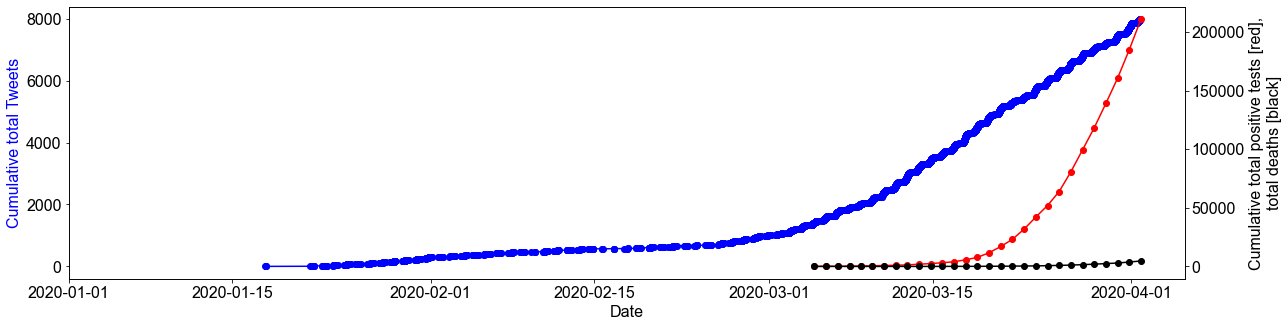

In [25]:
# Define df
df_plot = df_hc_covid_tweets.sort_values('created_at').reset_index()
series_pos = df_states_cases.groupby('dateChecked')['positive'].sum()
series_deaths = df_states_cases.groupby('dateChecked')['death'].sum()

# Define figure parameters
fsize=16
fig, axes = plt.subplots(figsize=(20, 5))
axes2 = axes.twinx()

axes.plot(df_plot['created_at'], df_plot.index, 'o-', color='blue')
axes2.plot(series_pos.index, series_pos, 'o-', color='red')
axes2.plot(series_deaths.index, series_deaths, 'o-', color='black')

axes.set_xlim(pd.Timestamp('2020-01-01'))
axes.set_ylabel('Cumulative total Tweets', color='blue')
axes2.set_ylabel('Cumulative total positive tests [red],\ntotal deaths [black]')
axes.set_xlabel('Date')
plt.show()

Show total Tweets and Tweets for each state

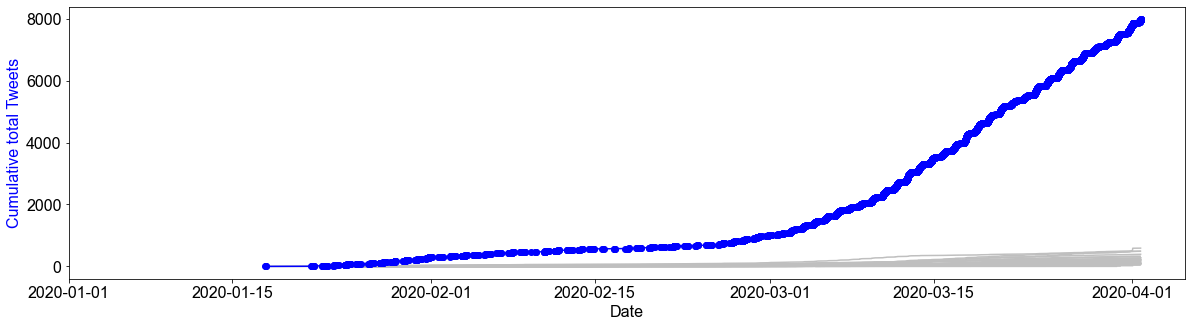

In [26]:
# Define df
df_plot = df_hc_covid_tweets.sort_values('created_at').reset_index()

# Define figure parameters
fsize=16
fig, axes = plt.subplots(figsize=(20, 5))

state_depts = df_hc_covid_tweets['State Health Department'].unique()

for state in state_depts:
    df_state = df_hc_covid_tweets[df_hc_covid_tweets['State Health Department'] == state]
    df_state = df_state.sort_values('created_at').reset_index()
    axes.plot(df_state['created_at'], df_state.index, '-', color='0.75')
axes.plot(df_plot['created_at'], df_plot.index, 'o-', color='blue')

axes.set_xlim(pd.Timestamp('2020-01-01'))
axes.set_ylabel('Cumulative total Tweets', color='blue')
axes.set_xlabel('Date')
plt.show()

It's hard to tell with total Tweets, so let's plot just individual states, with the ability to highlight one state of interest

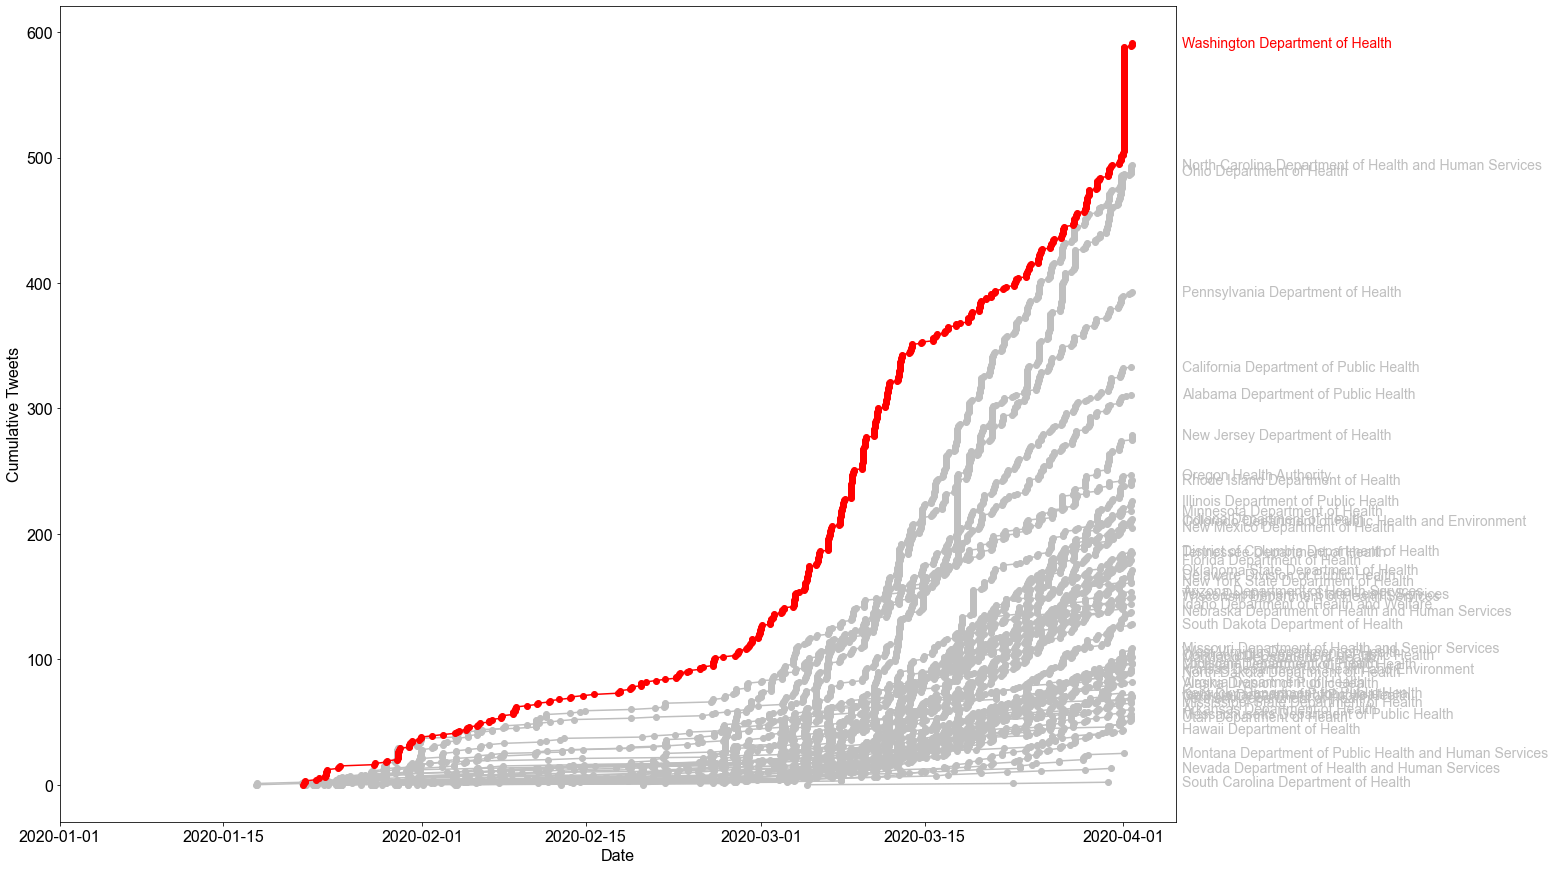

In [27]:
state = 'WA'
dept = df_hc_handles[df_hc_handles['Abbreviation'] == state]['State Health Department'].iloc[0]

# Define df
df_plot = df_hc_covid_tweets.sort_values('created_at').reset_index()

# Define figure parameters
fsize=16
fig, axes = plt.subplots(figsize=(20, 15))

state_depts = df_hc_covid_tweets['State Health Department'].unique()
state_depts = np.append(np.delete(state_depts, np.argwhere(state_depts==dept)[0][0]), dept)

for state_dept in state_depts:
    df_state = df_hc_covid_tweets[df_hc_covid_tweets['State Health Department'] == state_dept]
    df_state = df_state.sort_values('created_at').reset_index()
    if state_dept == dept:
        color = 'red'
    else:
        color = '0.75'
    axes.plot(df_state['created_at'], df_state.index, 'o-', color=color)

for line, name in zip(axes.lines, state_depts):
    y = line.get_ydata()[-1]
    if name == dept:
        color = 'red'
    else:
        color = '0.75'
    axes.annotate(name, xy=(1,y), xytext=(6,0), color=color,
                xycoords = axes.get_yaxis_transform(), textcoords="offset points",
                size=14, va="center")

axes.set_xlim(pd.Timestamp('2020-01-01'))
axes.set_ylabel('Cumulative Tweets')
axes.set_xlabel('Date')
plt.show()

What do COVID-19 tweets look like in comparison to the account normal tweets?

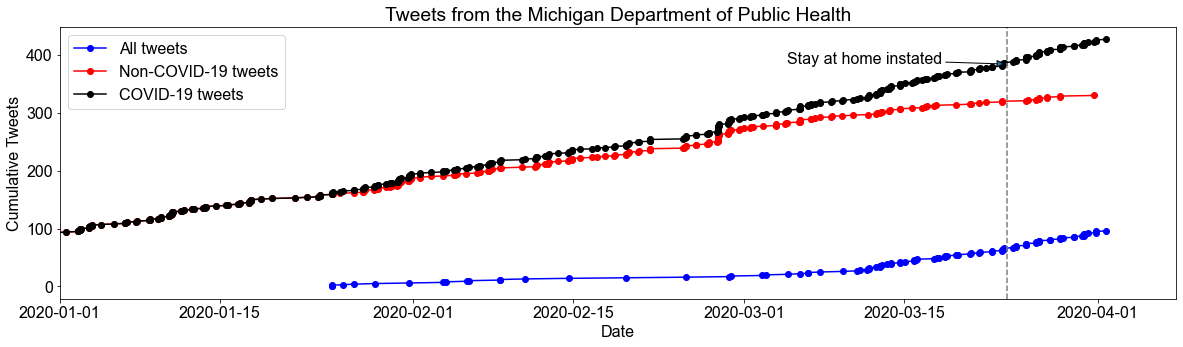

In [43]:
state = 'MI'

state_name = us.states.lookup(state).name
dept = df_hc_handles[df_hc_handles['Abbreviation'] == state]['State Health Department'].iloc[0]
sip_date = df_sip[df_sip['State'] == state_name]['Date effective'].iloc[0]

# Define df
df_plot = df_hc_covid_tweets[df_hc_covid_tweets['State Health Department'] == dept]
df_plot = df_plot.sort_values('created_at').reset_index()
df_plot2 = df_hc_tweets[
    (df_hc_tweets['State Health Department'] == dept) & 
    ~(df_hc_tweets['full_text'].str.contains(covid_strings, regex=True, case=False))
]
df_plot2 = df_plot2.sort_values('created_at').reset_index()
df_plot3 = df_hc_tweets[df_hc_tweets['State Health Department'] == dept]
df_plot3 = df_plot3.sort_values('created_at').reset_index()

# Define figure parameters
fsize=16
fig, axes = plt.subplots(figsize=(20, 5))

axes.plot(df_plot['created_at'], df_plot.index, 'o-', color='blue', label='All tweets')
axes.plot(df_plot2['created_at'], df_plot2.index, 'o-', color='red', label='Non-COVID-19 tweets')
axes.plot(df_plot3['created_at'], df_plot3.index, 'o-', color='black', label='COVID-19 tweets')

if pd.notnull(sip_date):
    sip_order = df_sip[df_sip['State'] == state_name]['Order'].iloc[0]
    axes.axvline(x=mdates.date2num(sip_date), linestyle='--', color='grey')
    axes.annotate(sip_order + ' instated', (mdates.date2num(sip_date), .9*max(df_plot3.index)), xytext=(-220,0), 
                textcoords='offset points', arrowprops=dict(arrowstyle='-|>'))

axes.set_xlim(pd.Timestamp('2020-01-01'))
axes.set_title('Tweets from the %s' %dept)
axes.set_ylabel('Cumulative Tweets')
axes.set_xlabel('Date')
axes.legend(loc='upper left')
plt.show()

In [29]:
df_plot2

,index,id,user,user_label,created_at,full_text,retweeted_status,retweeted_status_label,quoted_status,quoted_status_label,place,place_label,source,source_label,truncated,display_text_range,in_reply_to_status_id,in_reply_to_user_id,in_reply_to_screen_name,geo,coordinates,contributors,is_quote_status,retweet_count,favorite_count,favorited,retweeted,lang,possibly_sensitive,scopes,withheld_in_countries,State,Abbreviation,State Health Department,Website,Twitter Handle,Covid Page,Covid Twitter Handle,user_id
0,10698,1201199555448070145,59545968,WA Dept. of Health,2019-12-01 18:01:05+00:00,"If you’re driving for the holiday, make sure you’re rested and alert enough to drive. #SafeTravels https://twitter.com/WADeptHealth/status/1201199555448070145/photo/1",NaN,NaN,NaN,NaN,NaN,NaN,65485ce61484997de5ba0501f22e6a36fdd114bb,AgoraPulse Manager,0,"[0, 98]",NaN,NaN,NaN,NaN,NaN,NaN,0,1,2,0,0,en,0.0,NaN,NaN,Washington,WA,Washington Department of Health,https://www.doh.wa.gov/,WADeptHealth,NaN,NaN,59545968
1,10699,1201550900935839744,59545968,WA Dept. of Health,2019-12-02 17:17:13+00:00,It’s National Influenza Vaccination Week It’s not too late to get your flu shot! https://link.medium.com/aYfBJz5051,NaN,NaN,NaN,NaN,NaN,NaN,887710c0899816dfe9fb0176eb05d760cbe15732,Twitter Web Client,0,"[0, 104]",NaN,NaN,NaN,NaN,NaN,NaN,0,6,5,0,0,en,0.0,NaN,NaN,Washington,WA,Washington Department of Health,https://www.doh.wa.gov/,WADeptHealth,NaN,NaN,59545968
2,10700,1201622120339574785,59545968,WA Dept. of Health,2019-12-02 22:00:13+00:00,Mary got her high-dose #fluvaccine! #WhyIVAX #knockoutflu #NIVW Flu vaccines for people 65 and older: https://www.cdc.gov/flu/highrisk/65over.htm National Flu Vaccination Week is a great time to get your shot. https://twitter.com/WADeptHealth/status/1201622120339574785/photo/1,NaN,NaN,NaN,NaN,NaN,NaN,65485ce61484997de5ba0501f22e6a36fdd114bb,AgoraPulse Manager,0,"[0, 189]",NaN,NaN,NaN,NaN,NaN,NaN,0,1,1,0,0,en,0.0,NaN,NaN,Washington,WA,Washington Department of Health,https://www.doh.wa.gov/,WADeptHealth,NaN,NaN,59545968
3,10701,1201627660964659200,59545968,WA Dept. of Health,2019-12-02 22:22:14+00:00,"It's crucial that every Washingtonian is counted in the #2020Census. Among other important things, the census determines how much federal funding WA will get for projects that support our public infrastructure and services, from food stamps to health care programs and beyond. https://twitter.com/WAStateCommerce/status/1201592357919100928",NaN,NaN,1.201592e+18,1.201592e+18,NaN,NaN,1f89d6a41b1505a3071169f8d0d028ba9ad6f952,Twitter Web App,0,"[0, 276]",NaN,NaN,NaN,NaN,NaN,NaN,1,4,4,0,0,en,0.0,NaN,NaN,Washington,WA,Washington Department of Health,https://www.doh.wa.gov/,WADeptHealth,NaN,NaN,59545968
4,10702,1201954455014584321,59545968,WA Dept. of Health,2019-12-03 20:00:47+00:00,"Young people in the U.S. are in the middle of a vaping epidemic. In WA it will be illegal to sell tobacco & vapor products to anyone under 21 starting Jan. 1, 2020. This will protect kids from developing a lifelong addiction to nicotine, saving thousands of lives. #TV21WA #TV21 https://twitter.com/WADeptHealth/status/1201954455014584321/photo/1",NaN,NaN,NaN,NaN,NaN,NaN,65485ce61484997de5ba0501f22e6a36fdd114bb,AgoraPulse Manager,0,"[0, 282]",NaN,NaN,NaN,NaN,NaN,NaN,0,2,4,0,0,en,0.0,NaN,NaN,Washington,WA,Washington Department of Health,https://www.doh.wa.gov/,WADeptHealth,NaN,NaN,59545968
5,10703,1202028252065226752,59545968,WA Dept. of Health,2019-12-04 00:54:02+00:00,RT @HIVGov: #PrEP is a critical prevention strategy to #EndtheEpidemic. See how @HHSGov’s #ReadySetPrEP program increases access and brings…,1.201965e+18,1.201965e+18,NaN,NaN,NaN,NaN,1f89d6a41b1505a3071169f8d0d028ba9ad6f952,Twitter Web App,0,"[0, 140]",NaN,NaN,NaN,NaN,NaN,NaN,0,51,0,0,0,en,NaN,NaN,NaN,Washington,WA,Washington Department of Health,https://www.doh.wa.gov/,WADeptHealth,NaN,NaN,59545968
6,10704,1202367149156683776,59545968,WA Dept. of Health,2019-12-04 23:20:41+00:00,Join us in Bremert

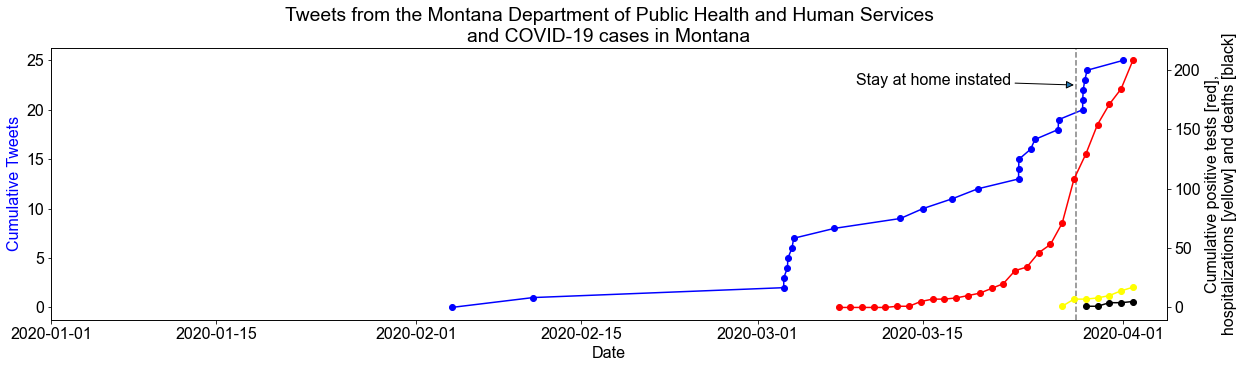

In [53]:
state = 'MT'

state_name = us.states.lookup(state).name
dept = df_hc_handles[df_hc_handles['Abbreviation'] == state]['State Health Department'].iloc[0]
sip_date = df_sip[df_sip['State'] == state_name]['Date effective'].iloc[0]

# Define df
df_plot = df_hc_covid_tweets[df_hc_covid_tweets['State Health Department'] == dept]
df_plot = df_plot.sort_values('created_at').reset_index()
df_state = df_states_cases[df_states_cases['state'] == state]

# Define figure parameters
fsize=16
fig, axes = plt.subplots(figsize=(20, 5))
axes2 = axes.twinx()

axes.plot(df_plot['created_at'], df_plot.index, 'o-', color='blue')
axes2.plot(df_state['dateChecked'], df_state['positive'], 'o-', color='red')
axes2.plot(df_state['dateChecked'], df_state['death'], 'o-', color='black')
axes2.plot(df_state['dateChecked'], df_state['hospitalized'], 'o-', color='yellow')

if pd.notnull(sip_date):
    sip_order = df_sip[df_sip['State'] == state_name]['Order'].iloc[0]
    axes.axvline(x=mdates.date2num(sip_date), linestyle='--', color='grey')
    axes.annotate(sip_order + ' instated', (mdates.date2num(sip_date), .9*max(df_plot.index)), xytext=(-220,0), 
                textcoords='offset points', arrowprops=dict(arrowstyle='-|>'))

axes.set_xlim(pd.Timestamp('2020-01-01'))
axes.set_title('Tweets from the %s\nand COVID-19 cases in %s' %(dept, us.states.lookup(state).name))
axes.set_ylabel('Cumulative Tweets', color='blue')
axes2.set_ylabel('Cumulative positive tests [red],\nhospitalizations [yellow] and deaths [black]')
axes.set_xlabel('Date')
plt.show()

In [243]:
df_plot

,index,id,user,user_label,created_at,full_text,retweeted_status,retweeted_status_label,quoted_status,quoted_status_label,place,place_label,source,source_label,truncated,display_text_range,in_reply_to_status_id,in_reply_to_user_id,in_reply_to_screen_name,geo,coordinates,contributors,is_quote_status,retweet_count,favorite_count,favorited,retweeted,lang,possibly_sensitive,scopes,withheld_in_countries,State,Abbreviation,State Health Department,Website,Twitter Handle,Covid Page,Covid Twitter Handle,user_id
0,12279,1219779061376962560,33934492,CA Public Health,2020-01-22 00:29:25+00:00,"RT @CDCgov: CDC is closely monitoring an outbreak of 2019 novel #coronavirus in Wuhan, China. Get the latest updates from CDC for\n✈️Travele…",1.219305e+18,1.219305e+18,NaN,NaN,NaN,NaN,1f89d6a41b1505a3071169f8d0d028ba9ad6f952,Twitter Web App,0,"[0, 140]",NaN,NaN,NaN,NaN,NaN,NaN,0,329,0,0,0,en,NaN,NaN,NaN,California,CA,California Department of Public Health,https://www.cdph.ca.gov/,CAPublicHealth,NaN,NaN,33934492
1,12284,1220407747356831744,33934492,CA Public Health,2020-01-23 18:07:35+00:00,The California Department of Public Health has issued a health update and interim guidance for healthcare facilities on the #coronavirus. Click here: https://bit.ly/2RN3R4B\n\n#CDPH #nCoV2019,NaN,NaN,NaN,NaN,NaN,NaN,ef22bdcbaf9be5b60db28a05006e3f3ebc1fa61d,Hootsuite Inc.,0,"[0, 190]",NaN,NaN,NaN,NaN,NaN,NaN,0,30,25,0,0,en,0.0,NaN,NaN,California,CA,California Department of Public Health,https://www.cdph.ca.gov/,CAPublicHealth,NaN,NaN,33934492
2,12285,1220527816569016320,33934492,CA Public Health,2020-01-24 02:04:42+00:00,"@CAPublicHealth is working closely w/@CDCgov and local health jurisdictions to respond to an outbreak of novel coronavirus in China and several other countries. As of Jan. 23, 2020, no cases have been confirmed in the state of California. Visit http://cdph.ca.gov for info.",NaN,NaN,NaN,NaN,NaN,NaN,1f89d6a41b1505a3071169f8d0d028ba9ad6f952,Twitter Web App,0,"[0, 278]",NaN,3.393449e+07,CAPublicHealth,NaN,NaN,NaN,0,5,3,0,0,en,0.0,NaN,NaN,California,CA,California Department of Public Health,https://www.cdph.ca.gov/,CAPublicHealth,NaN,NaN,33934492
3,12286,1220761502950420480,33934492,CA Public Health,2020-01-24 17:33:17+00:00,"@CAPublicHealth is working closely with @CDCgov and local health jurisdictions to respond to an outbreak of novel #coronavirus in China and several other countries. As of Jan. 23, 2020, no cases have been confirmed in the state of CA. #nCoV2019 #CDPH 1/2",NaN,NaN,NaN,NaN,NaN,NaN,1f89d6a41b1505a3071169f8d0d028ba9ad6f952,Twitter Web App,0,"[0, 254]",NaN,3.393449e+07,CAPublicHealth,NaN,NaN,NaN,0,4,5,0,0,en,NaN,NaN,NaN,California,CA,California Department of Public Health,https://www.cdph.ca.gov/,CAPublicHealth,NaN,NaN,33934492
4,12287,1220761573829988352,33934492,CA Public Health,2020-01-24 17:33:34+00:00,"@CDCgov If you feel ill after recent travel to China, please call your health care provider or local health department. Be sure to mention your travel history. #coronavirus #nCoV2019 #CDPH 2/2",NaN,NaN,NaN,NaN,NaN,NaN,1f89d6a41b1505a3071169f8d0d028ba9ad6f952,Twitter Web App,0,"[8, 192]",1.220762e+18,3.393449e+07,CAPublicHealth,NaN,NaN,NaN,0,2,1,0,0,en,NaN,NaN,NaN,California,CA,California Department of Public Health,https://www.cdph.ca.gov/,CAPublicHealth,NaN,NaN,33934492
5,12292,1220875622433427456,33934492,CA Public Health,2020-01-25 01:06:45+00:00,"RT @CDPHDirector: You may have heard about the novel #coronavirus that's causing respiratory illness in China and a few other countries, in…",1.220876e+18,1.220876e+18,NaN,NaN,NaN,NaN,1f89d6a41b1505a3071169f8d0d028ba9ad6f952,Twitter Web App,0,"[0, 140]",NaN,NaN,NaN,NaN,NaN,NaN,0,30,0,0,0,en,NaN,NaN,NaN,California,CA,California Department of Public Health,https://www.cdph.ca.gov/,CAPublicHealth,NaN,NaN,33934492
6,12293,1220896693920485377,33934492,CA Public Health,2020-01-25 02:30:29+00:00,"Dr. Sonia Angell, Director of the California Department of Public Health and State Public Health O

Get a feel for engagement with and by the account:
* Engagement by the account: total number of Tweets that are retweets or quotes
* Engagement with the account: total retweets of this acccount's Tweets

Top accounts this account engaged with?

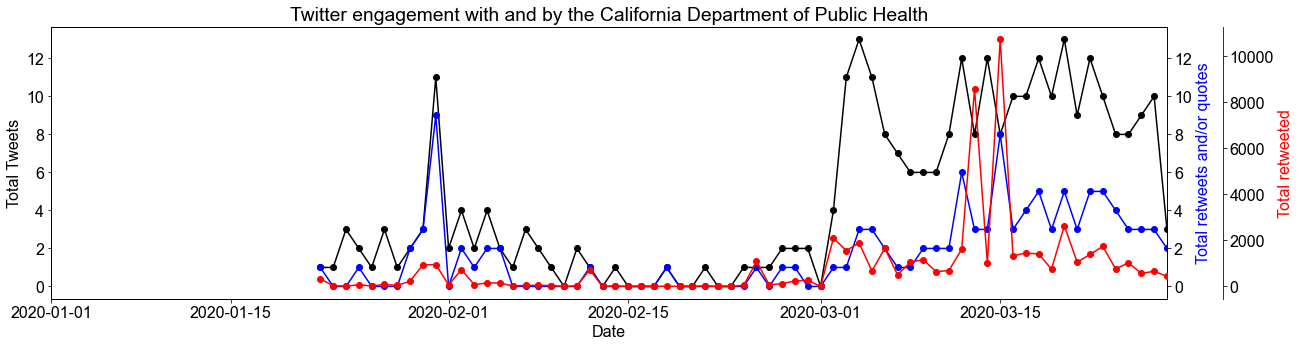

In [47]:
state = 'CA'

dept = df_hc_handles[df_hc_handles['Abbreviation'] == state]['State Health Department'].iloc[0]

# Define df
df_plot = df_hc_covid_tweets[df_hc_covid_tweets['State Health Department'] == dept]
df_total = df_plot[['created_at']].resample('D', on='created_at').count()
df_engaged_with_counts = df_plot[['created_at', 'retweeted_status', 'quoted_status']].resample('D', on='created_at').count()
series_engaged_with = df_engaged_with_counts.drop(columns=['created_at']).sum(axis=1)
df_engaged_by = df_plot[['created_at', 'retweet_count']].resample('D', on='created_at').sum()

# Define figure parameters
fsize=16
fig, axes = plt.subplots(figsize=(20, 5))
axes2 = axes.twinx()
axes3 = axes.twinx()
rspine = axes3.spines['right']
rspine.set_position(('axes', 1.05))

axes.plot(df_total.index, df_total, 'o-', color='black')
axes2.plot(series_engaged_with.index, series_engaged_with, 'o-', color='blue')
axes3.plot(df_engaged_by.index, df_engaged_by['retweet_count'], 'o-', color='red')

axes.set_xlim(pd.Timestamp('2020-01-01'), pd.Timestamp('2020-03-28'))
axes2.set_ylim(axes.get_ylim())
axes.set_title('Twitter engagement with and by the %s' %dept)
axes.set_ylabel('Total Tweets', color='black')
axes2.set_ylabel('Total retweets and/or quotes', color='blue')
axes3.set_ylabel('Total retweeted', color='red')
axes.set_xlabel('Date')
plt.show()

* test results?